In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
pip install SimpleITK

     |████████████████████████████████| 42.5MB 210kB/s 


In [8]:
%cd /content/drive/My Drive/ProstrateX2/Code/Preprocessing

/content/drive/My Drive/ProstrateX2/Code/Preprocessing


Generate tables if they are not generated

In [0]:
#Generate Tables
#!python generate_tables.py

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import SimpleITK as sitk

from skimage import exposure
from pathlib import Path

## load training_tables
t2_train_table = pd.read_pickle('/content/drive/My Drive/ProstrateX2/Dataset/Training/tables/t2_train.pkl')
adc_train_table = pd.read_pickle('/content/drive/My Drive/ProstrateX2/Dataset/Training/tables/adc_train.pkl')
bval_train_table = pd.read_pickle('/content/drive/My Drive/ProstrateX2/Dataset/Training/tables/bval_train.pkl')
ktrans_train_table = pd.read_pickle('/content/drive/My Drive/ProstrateX2/Dataset/Training/tables/ktrans_train.pkl')

def load_image(path_to_resampled_file):
    sitk_image = sitk.ReadImage(str(path_to_resampled_file))
    image_array = sitk.GetArrayViewFromImage(sitk_image)
    return sitk_image, image_array

def calculate_location_of_finding(sitk_image, reported_position):
    location_of_finding = sitk_image.TransformPhysicalPointToIndex(reported_position)
    return location_of_finding

def calculate_origin_size_patch(location_of_finding, desired_patch_size):
    x = location_of_finding[0]
    y = location_of_finding[1]
    rect_x = x - desired_patch_size // 2 
    rect_y = y - desired_patch_size // 2
    return (rect_x, rect_y, desired_patch_size)

def equalize_image(image_array):
    image_array = exposure.equalize_hist(image_array)
    return image_array

def extract_patch(image_array, location_of_finding, desired_patch_size):
    x = location_of_finding[0]
    y = location_of_finding[1]

    arr_x_start_index = x - (desired_patch_size // 2)
    arr_x_end_index = x + (desired_patch_size // 2)
    arr_y_start_index = y - (desired_patch_size // 2)
    arr_y_end_index = y + (desired_patch_size // 2)

    extracted_patch = image_array[location_of_finding[2], arr_y_start_index:arr_y_end_index, arr_x_start_index:arr_x_end_index]
    return extracted_patch

def plot_sig_sequence_for_patient(patient_id, desired_sequence, desired_patch_size):
    significant_sequences = pd.DataFrame()
    
    def plot_image_with_selection(image_array, location_of_finding, origin_size_patch, desired_patch_size):
        fig, ax = plt.subplots(1)
        ax.imshow(image_array[location_of_finding[2],:,:], cmap = 'gray', origin = 'lower')
        rect = patches.Rectangle((origin_size_patch[0], origin_size_patch[1]), desired_patch_size, desired_patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

    if desired_sequence == 't2':
        significant_sequences = t2_train_table[(t2_train_table['ClinSig'] == True) & (t2_train_table['ProxID'] == patient_id)]
    elif desired_sequence == 'adc':
        significant_sequences = adc_train_table[(adc_train_table['ClinSig'] == True) & (adc_train_table['ProxID'] == patient_id)]
    elif desired_sequence == 'bval':
        significant_sequences = bval_train_table[(bval_train_table['ClinSig'] == True) & (bval_train_table['ProxID'] == patient_id)]
    elif desired_sequence == 'ktrans':
        significant_sequences = ktrans_train_table[(ktrans_train_table['ClinSig'] == True) & (ktrans_train_table['ProxID'] == patient_id)]

    for row in significant_sequences.itertuples():
        path_to_resampled_file = getattr(row, 'path_to_resampled_file')
        reported_position = getattr(row, 'pos')
        reported_position=tuple([float(i) for i in reported_position.split()])
        sitk_image, image_array = load_image(path_to_resampled_file)
        location_of_finding = calculate_location_of_finding(sitk_image, reported_position)
        origin_size_patch = calculate_origin_size_patch(location_of_finding, desired_patch_size)
        equalized_image_array = equalize_image(image_array)
        unaltered_patch = extract_patch(image_array, location_of_finding, desired_patch_size)
        equalized_patch = extract_patch(equalized_image_array, location_of_finding, desired_patch_size)
        
        # plot unaltered image with cancer selection
        plot_image_with_selection(image_array, location_of_finding, origin_size_patch, desired_patch_size)
        
        

        # plot equalized image with cancer selection
        plot_image_with_selection(equalized_image_array, location_of_finding, origin_size_patch, desired_patch_size)

        # plot unaltered patch
        plt.imshow(unaltered_patch, cmap = 'gray', origin = 'lower')
        plt.show()

        # plot equalized patch
        plt.imshow(equalized_patch, cmap = 'gray', origin = 'lower')

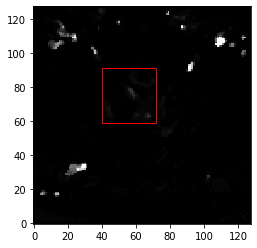

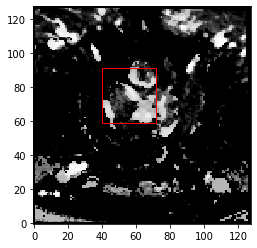

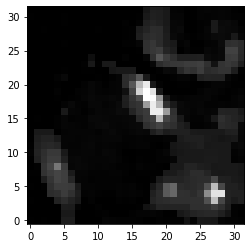

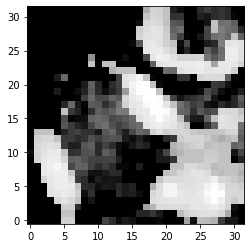

In [11]:
plot_sig_sequence_for_patient('ProstateX-0000', 't2', 32)

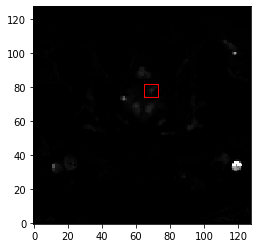

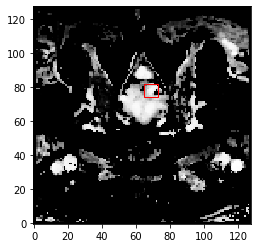

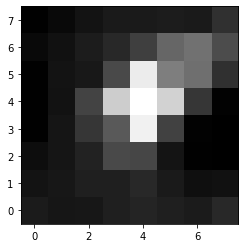

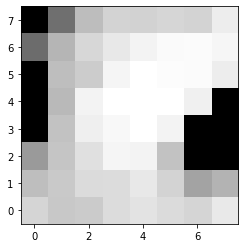

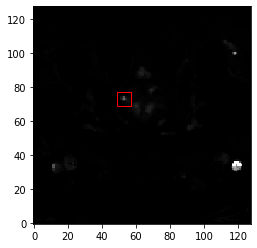

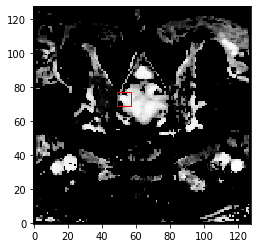

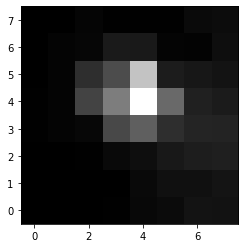

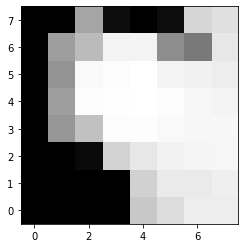

In [12]:
plot_sig_sequence_for_patient('ProstateX-0005', 'adc', 8)

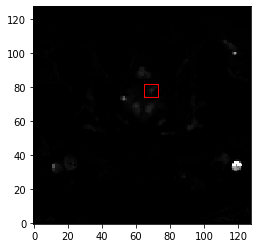

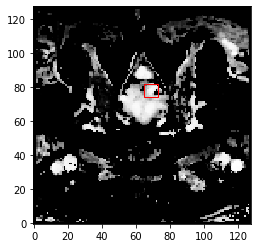

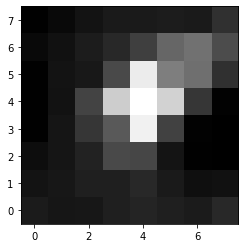

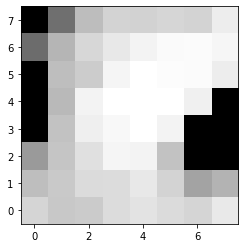

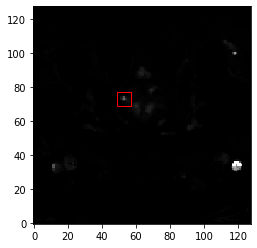

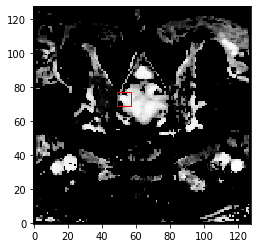

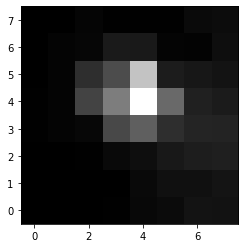

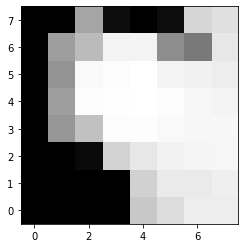

In [13]:
plot_sig_sequence_for_patient('ProstateX-0005', 'bval', 8)

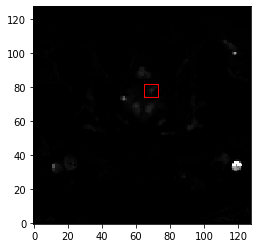

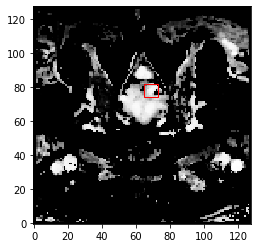

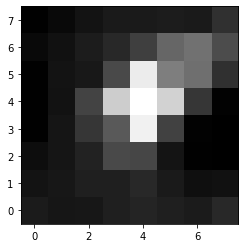

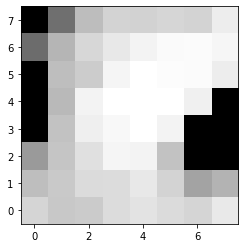

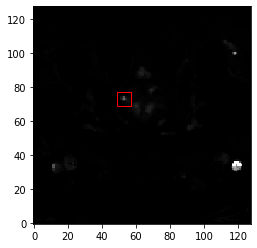

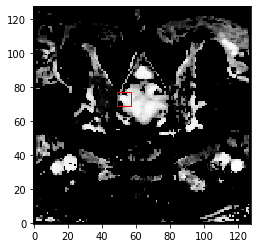

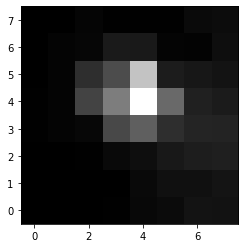

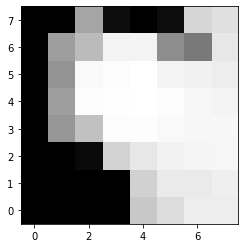

In [14]:
plot_sig_sequence_for_patient('ProstateX-0005', 'ktrans', 8)

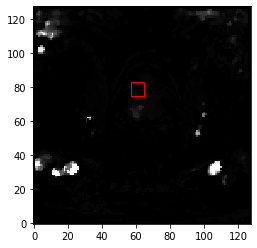

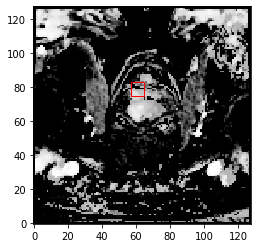

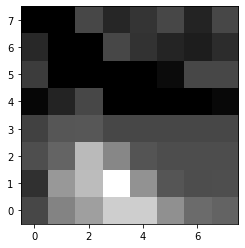

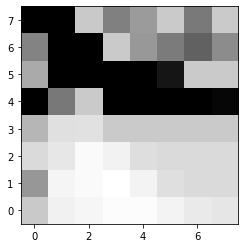

In [15]:
plot_sig_sequence_for_patient('ProstateX-0019', 'adc', 8)